In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import numpy as np
import datetime

In [2]:
# Define the start and end times of the desired dataset

start_time = '2018-12-12T06:00:00+13'
end_time = '2019-12-12T06:00:00+13'

# Parse data

quake_cat = pd.read_csv('./quakehistory-23052019.csv', parse_dates=[3, 4])

pd.set_option('display.max_columns', None)  # Allow all of the DataFrame to be printed

# Sort data by publicid, then by modification time

quake_cat = quake_cat.sort_values(by=['publicid','modificationtime'])

# Trim the data to the time period specified

quake_cat['time'] = pd.to_datetime(quake_cat['time']) # convert times to datetime64 objects
quake_cat = quake_cat.loc[((quake_cat['time'] >= pd.to_datetime(start_time)) &
                           (quake_cat['time'] <= pd.to_datetime(end_time)))]

In [3]:
# Find the first manually reviewed origin for each eventid, if one exists

manual = quake_cat.loc[(quake_cat['evaluationmode'] == 'manual') & (quake_cat['type'] == 'earthquake')]
manual = manual.sort_values(by=['modificationtime'])
manual = manual.groupby('publicid').nth(0).reset_index()

# Find those events with both a manual and automatic origin, then find the first automatic origin for such events

automatic = quake_cat.loc[(quake_cat['evaluationmode'] == 'automatic')]
automatic = automatic.loc[automatic['publicid'].isin(manual.publicid)]
automatic = automatic.sort_values(by=['modificationtime'])
automatic = automatic.groupby('publicid').nth(0).reset_index()

# Filter the first manual origins of events such that only those with a corresponding automatic origin are kept

manual = manual.loc[manual['publicid'].isin(automatic.publicid)]

# Reset the index for the manual dataframe after matching against automatic events, then remove the old index

manual = manual.reset_index()
manual = manual.drop('index', 1)

Now calculate the Review Time (RT) of an event as the difference between the first automatic origin ($AT^{1}$) and the first manual origin ($MT^{1}$). This assumes that the first automatic origin is coincident with the "earthquake occurence in New Zealand" as per the EQC contract.

$RT = AT^{1} - MT^{1}$

Add also to the DataFrame columns for analysis: magnitude bins, GHA shifts, and GHA colours for each event.

In [4]:
# Convert times to datetime objects

manual['modificationtime'] = pd.to_datetime(manual['modificationtime']).dt.tz_convert('UTC')
automatic['modificationtime'] = pd.to_datetime(automatic['modificationtime']).dt.tz_convert('UTC')

# Calculate review times

RT =  pd.DataFrame((manual['modificationtime'] - automatic['modificationtime']))
RT.columns = ['delta']

# Calculate review time in minutes for analysis

RT['minutes'] = (RT['delta'].dt.total_seconds() / 60)

# Add other columns from the manual origin for use in analysis

RT['MT'] = manual['modificationtime']
RT['MT_NZT'] = manual['modificationtime'].dt.tz_convert('NZ')
RT['magnitude'] = manual['magnitude']
RT['latitude'] = manual['latitude']
RT['longitude'] = manual['longitude']

# Add columns for use in data splitting: magnitude (rounded to nearest unit), GHA shift, and GHA colour

### Round magnitude to nearest integer

RT['int_magnitude'] = RT['magnitude'].round(0).astype(int)

In [5]:
# Define a function for calculating a distribution

def calculate_distribution(data_list, round_to):

    """
    Calculate the distribution of a list of floats, where floats are rounded to the nearest round_to value.
    :param data_list: list of data values
    :param round_to: value to round data to for distribution calculation, e.g. 0.1 rounds data to the nearest 0.1
    :return: data values in distribution for which data exists, number of data > 0 at each data value
    """
    
    # First, prepare data for distribution calculation ("rounding") and remove nan values (nn = non-nan)
    
    nn_rounded_data_list = []
    for i in range(len(data_list)):
        try:
            if round_to <= 1:
                # Here "inflate" decimal data to integers to make distribution calculation easier
                nn_rounded_data_list.append(int(round((1 / round_to) * data_list[i])))
            else:
                # Here simply round the data to the nearest value
                nn_rounded_data_list.append(int(round(data_list[i] / round_to)))
        except:  # Fails on nan values
            pass

    # Prepare distribution lists
        
    data_counts = [0] * int(max(nn_rounded_data_list) + 1)
    data_values = list(range(max(nn_rounded_data_list) + 1))

    # Calculate distribution
    
    for i in data_values:
        if nn_rounded_data_list.count(i) > 0:
            data_counts[i] = nn_rounded_data_list.count(i)

    # If rounding to a decimal, convert data values to decimal values
            
    if round_to <= 1:
        for i in range(len(data_values)):
            data_values[i] /= (1 / round_to)
            
    # For later analytical efficiency, remove points with 0 values in distribution

    DVNZ = []  # data values non zero
    DCNZ = []  # data counts non zero
    for n in range(len(data_counts)):
        if data_counts[n] > 0:
            DVNZ.append(data_values[n])
            DCNZ.append(data_counts[n])

    return DVNZ, DCNZ

Now that we have all the review times for the events in our data, we need to study the data distribution to identify any outliers that could skew our statistics. To do this we use a distribution plot which sums rounded review times over the range of review times and plots the number of a given review time against the review time.

By changing the rounding value we use in distribution calculation we can view data trends at different temporal scales. For example, rounding to the nearest 1440 minutes will produce the review time distribution in nearest days, while rounding to the nearest 1 minute will produce the review time distribution in nearest minutes. Using a larger rounding value will show broader trends in time, but will reduce the fidelity of the data. It is good to use large rounding values when the distribution is not apparent, i.e. when data is scattered over time and does not cluster at low rounding values.

Because the data are contaminated by many aspects of the earthquake location system and operational process, there are many filtering options available below. I recommend the following strategy:

1. Disable all filtering by using None or False parameters where appropriate and run the distribution plotting.
1. Investigate the unfiltered distribution at multiple rounding values to see trends over different time scales, then determine if you want to add time filtering.
1. Run the distribution with time filtering, adjusting it as appropriate until it contains only the desired data.
1. Now, if you like, begin playing with time windowing to look at distribution trends over time.
1. Similarly, if you like, try the different data splitting options to investigate how different aspects of the data contribute to the overall distribution. You can only split the data one way at a time using these options, but you can focus the splitting on certain subsets of the data by setting the other splitting parameters to given values in the relevant columns of the DataFrame, e.g. to see the distribution of review times split by magnitude for the green colour on the early shift have:
```
by_magnitude = True
```

There are few limits on how much you can spread the data out in this plotting, so be careful not to overwhelm yourself!

In [1]:
# Set parameters for distribution plotting: time window for rolling analysis, 
# data splitting/fixing (by magnitude, shift, or colour), and RT value rounding.
# Note that RT filtering time windowing, and data splitting are all optional, but rounding is required.

### Data filtering by RT value

filter_window = [None, 90]  # data subset for distribution plotting (in minutes),
                              # set to None to perform no data subsetting,
                              # set either limit to None to exclude filtering by this limit
        
### Spatial data filtering

filter_box = [-49, -33, 163, 185]  # minlat, maxlat, minlon, maxlon for box to analyse earthquake review times in

### Split data by time windows around the data's modification time
        
time_window = None  # time window to bin data by in seconds, set to None to perform no windowing
window_overlap = 0.8 # percentage each time window should overlap (disabled by time_window = None)

### Data splitting/fixing by magnitude

by_magnitude = False  # whether to split data by magnitude, or which magnitude data to include "fix" in plotting

### What value to round RT values to
        
rounding_value = 1  # number to round to in minutes, can be any real number

Filtering review times to those between limits: [None - 90] minutes
Number of values before filtering is: 3377
Number of values remaining after filtering is: 652
Filtering earthquakes to those in the box between latitudes -49 and -33 and longitudes 163 and 185
No data splitting will be performed.
No data time binning has been performed.
Calculating distribution(s)...
Plotting distribution(s)...


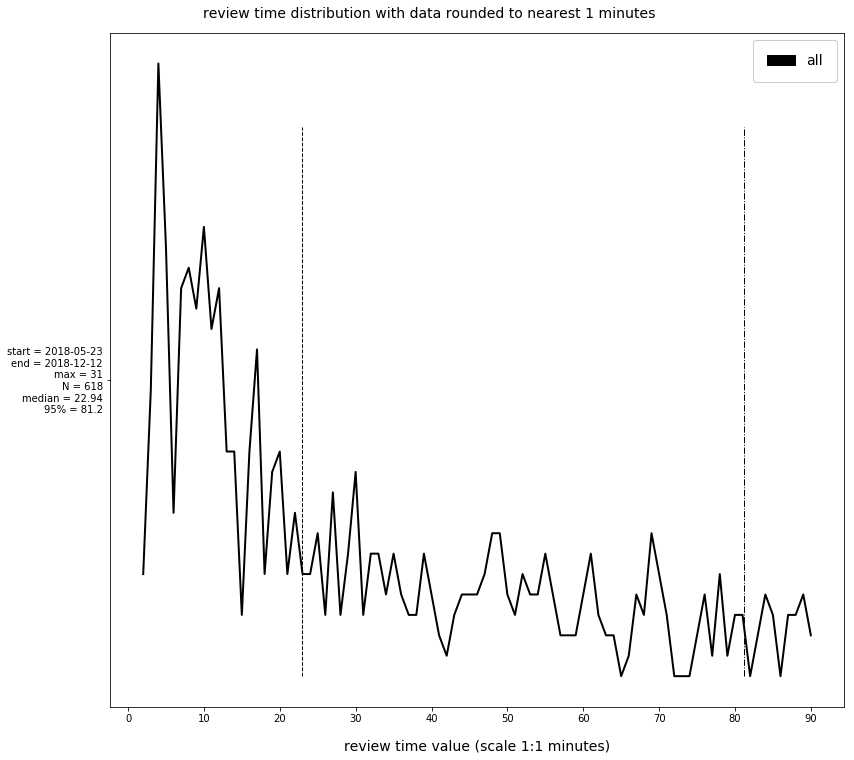

In [7]:
# Plot the data distribution(s)

# Set the colours to use in plotting from the shift sequence colours (assuming max subsets for plotting = 7!)

colours = ['black'] + colour_sequence + ['orange']  # black for all data, orange for an extra plotting colour
    
# Apply temporal filtering

if filter_window:
    print('Filtering review times to those between limits: [' + str(filter_window[0]) + ' - ' + 
          str(filter_window[1]) + '] minutes')
    print('Number of values before filtering is: ' + str(len(RT['minutes'].values)))
    if filter_window[0] and filter_window[1]:
        analysis_data = RT.loc[(RT['minutes'] >= filter_window[0]) & (RT['minutes'] <= filter_window[1])]
    elif filter_window[0] and not filter_window[1]:
        analysis_data = RT.loc[(RT['minutes'] >= filter_window[0])]
    elif filter_window[1] and not filter_window[0]:
        analysis_data = RT.loc[(RT['minutes'] <= filter_window[1])]
    elif not filter_window[0] and not filter_window[1]:
        analysis_data = RT
    print('Number of values remaining after filtering is: ' + str(len(analysis_data['minutes'].values)))
else:
    print('No data filtering has been performed.')
    analysis_data = RT
    
# Apply spatial filtering

if filter_box:
    print('Filtering earthquakes to those in the box between latitudes '
         + str(filter_box[0]) + ' and ' + str(filter_box[1]) + ' and longitudes ' + str(filter_box[2])
         + ' and ' + str(filter_box[3]))
    analysis_data = analysis_data.loc[((analysis_data['latitude'] >= filter_box[0]) &
                                     (analysis_data['latitude'] <= filter_box[1]) &
                                     (analysis_data['longitude'] >= filter_box[2]) &
                                     (analysis_data['longitude'] <= filter_box[3]))]
else:
    print('No spatial filtering has been performed.')
    
# Set up splitting factors
    
if by_magnitude == True:
    print('Splitting data by magnitude...')
    splitting_column = 'int_magnitude'
    splitting_factors = ['all', 1, 2, 3, 4, 5, 6]
else:
    print('No data splitting will be performed.')
    splitting_factors = ['all']
    
# Apply any factor fixing to the data

if by_magnitude and by_magnitude != True:
    print('Subsetting data to that with integer magnitude == ' + str(by_magnitude) + ' ...')
    analysis_data = analysis_data.loc[(analysis_data['int_magnitude'] == by_magnitude)]

# Initiate time windowing of data

if time_window:
    print('Binning data by time windows...')
    window_start = min(analysis_data['MT'].values)
    window_end = window_start + np.timedelta64(time_window, 's')
else:
    print('No data time binning has been performed.')
    time_window = 1  # This will break the while loop following the first while loop iteration
    window_overlap = 0
    window_start = min(analysis_data['MT'].values)
    window_end = max(analysis_data['MT'].values)

# Run the data analysis to generate the distribution(s)

print('Calculating distribution(s)...')
    
analytics_data_types = ['data_values', 'data_counts', 'median', '95_perc', 'start_time', 'end_time', 'split_idx']
analytics_data = [[] for i in range(len(analytics_data_types))]

last_data = max(analysis_data['MT'].values)
while window_end <= last_data:

    # Gather data for current time window

    current_window_data = analysis_data.loc[(analysis_data['MT'].values >= window_start) & 
                                           (analysis_data['MT'].values <= window_end)]        
    
    # Apply data splitting
    
    for i in range(len(splitting_factors)):
        
        # Gather data for current split
        
        if splitting_factors[i] == 'all':  # Analyse all data in the time window first
            current_data = current_window_data
        else:
            current_data = current_window_data.loc[current_window_data[splitting_column] == splitting_factors[i]]

        # Calculate the data distribution

        data_list = list(current_data['minutes'].values)
        if len(data_list) > 0:
            data_values, data_counts = calculate_distribution(data_list, rounding_value)

            # Store the data for analysis

            analytics_data[0].append(data_values)
            analytics_data[1].append(data_counts)
            analytics_data[2].append((round(np.percentile(data_list, 50), 2)))
            analytics_data[3].append((round(np.percentile(data_list, 95), 2)))
            analytics_data[4].append(str(window_start)[:10])
            analytics_data[5].append(str(window_end)[:10])
            analytics_data[6].append(i)

    # Update time loop parameters

    window_start += np.timedelta64(round(time_window * (1 - window_overlap)), 's')  
    window_end += np.timedelta64(round(time_window * (1 - window_overlap)), 's')
    
print('Plotting distribution(s)...')
    
# Plot the distribution(s)

if len(analytics_data[0]) > 5:
    y_len = (12 * (len(analytics_data[0]) / 6))
else:
    y_len = 12

fig, ax = plt.subplots(figsize=(12, y_len))

badges = []
max_data_counts = []
y_labels = []
for i in range(len(analytics_data[0])):
    
    # Prepare y labels

    max_data_count = max(analytics_data[1][i])
    y_labels.append('start = ' + analytics_data[4][i] + 
                    '\nend = ' + analytics_data[5][i] + 
                    '\nmax = ' + str(max_data_count) + 
                    '\nN = ' + str(sum(analytics_data[1][i])) + 
                    '\nmedian = ' + str(analytics_data[2][i]) + 
                    '\n95% = ' + str(analytics_data[3][i]))
    
    # Normalise each distribution
    
    normalised_data_counts = []
    for j in range(len(analytics_data[0][i])):
        normalised_data_counts.append((analytics_data[1][i][j] / max_data_count) + i - 0.5)

    # Plot the medians and 95% values of each distribution

    plt.plot([analytics_data[2][i]] * 2, [min(normalised_data_counts), max(normalised_data_counts) - 0.1],
             color='k', linestyle='--', linewidth=1)
    plt.plot([analytics_data[3][i]] * 2, [min(normalised_data_counts), max(normalised_data_counts) - 0.1],
             color='k', linestyle='-.', linewidth=1)
    
    # Plot each distribution
    
    plt.plot(analytics_data[0][i], normalised_data_counts, color=colours[analytics_data[6][i]], linewidth=2)
    badges.append(patches.Patch(color=colours[analytics_data[6][i]], 
                                label=splitting_factors[analytics_data[6][i]]))

# Add figure formatting

ax.set_yticks(list(range(len(analytics_data[0]))))
ax.set_yticklabels(y_labels)
plt.locator_params(axis='x', nbins=10)
plt.xlabel('review time value (scale 1:' + str(rounding_value) + ' minutes)', labelpad=15, fontsize=14)

badges = badges[:len(splitting_factors)]
badges.reverse()
plt.legend(handles=badges, fontsize=14, framealpha=1, borderpad=1, labelspacing=0.75, handlelength=2,
          columnspacing=1)

plt.subplots_adjust(left=0.13, right=0.98, bottom=0.12, top=0.9)
fig.suptitle('review time distribution with data rounded to nearest ' + str(rounding_value) + 
             ' minutes', y=0.93, fontsize=14)

# Show the plot!

plt.savefig('distribution.png', format='png', dpi=300)
plt.show()